# Getting started tutorial

## 1. Import of Python packages

A Python package is Python code written by someone else that can be imported into Python so you get access to it. Other words used for packages are modules or libraries. 
A package that contains many functions we need for scientific calculations is named `numpy`.
For example to import the function for calculating square roots we can write:

```python
from numpy import sqrt
print(sqrt(4))
```

To import all function within a package you can use the symbol "`*`", instead of using the name of the
function we want:

```python
from numpy import*
```

Note that, a Python package it self can consist of several other packages. For example we can import from the analysis package `exana` only the statistics package:


```python
from exana.statistics import* 
```

However, this way of importing packages is risky, because we can run into name clashes. This
is the case if for instance two functions in different packages have the same name. 
It therefore recommended to either (1) import only what you need, as we did in the first example, or (2) import packages explicitly with an "alias". For example we can import the `numpy` package with the alias `np`:


```python
import numpy as np
print(np.sqrt(4))
```
Now, all functions in `numpy` are available by writing `np.<name_of_function>`. 


<br>
<div class="alert alert-info">
To see the list of functions available you can write <code>np.</code> (after that package is imported) and then press <kbd>tab</kbd>.
</div>



The most common native Python packages we use are:

In [1]:
import numpy as np                 # mathmatical functions
import matplotlib.pyplot as plt    # plotting
import quantities as pq            # units (sec, meter, etc.)

<br>
<div class="alert alert-info">
<b>Tips:</b> By adding <code>plt.style.use('seaborn')</code>, i.e. using seaborn as theme in matplotlib, you get prettier plots:
</div>


In [2]:
plt.style.use('seaborn')

## 2. Notebook magic

You may sometimes see these lines at the top of notebooks:

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The first two lines make sure that the packages you use in the current notebook is automatically reloaded if they are changed outside Jupyter.

The last line makes sure that plots are interactive and shown in the notebook.

## 3. Projects and actions

### 3.1 Reading project:
In expipe every project has one or multiple actions. An action is usually an axona session. 
To get a project you can type (change project path):

In [4]:
import pathlib
import expipe
project_path = pathlib.Path(r'/home/m/repos/MROS_V1') # CHANGE PROJECT PATH!
project = expipe.get_project(project_path)
project

database_version: 2 project: MROS_V1 type: project

None

To see a list of all actions in the project:

In [5]:
actions = project.actions
actions

### 3.2 Reading an action:

A specific action can be required by using the action-id:  `project.actions[<action-id>]`:

In [6]:
action = actions["010-060120-11"] # axona_action

From the this action object you can then get the Exdir file where the corresponding data is stored:

In [7]:
import exdir
import exdir.plugins.quantities

exdir_path = action.data_path() / "main.exdir"
exdir_file = exdir.File(exdir_path, plugins=[exdir.plugins.quantities])

Here, `action.data_path()` returns the path to folder containing the Exdir file. To see all folders in the `exdir_file` you can write:

In [8]:
for name in exdir_file:
    print(name)

acquisition
epochs
figures
general
processing


## 4. Reading data in Neo

To analyze the data we need to read data in Neo which is  a package for representing electrophysiology data in Python.

### 4.1 Get epochs

<br>
<div class="alert alert-warning">
<b>IMPORTANT:</b> The code below assumes that you have created visual stimulus epoch. For axona data, this can be done by running <code>generate_stim_group_and_epoch(action)</code> in <code>axona_helper.py</code>
</div>


To load all epochs in one action:

In [9]:
import visualstimulation as vs

epochs = vs.data_processing.load_epochs(exdir_path)

# List all epochs:
for epoch in epochs:
    display(epoch.annotations)

{'lazy_shape': None,
 'exdir_path': '/epochs/open-ephys-epochs/rhythm_fpga_101',
 'node_id': 101,
 'processor': 'rhythm_fpga',
 'provenance': 'open-ephys'}

{'lazy_shape': None,
 'exdir_path': '/epochs/psychopy',
 'provenance': 'psychopy'}

We can get stimulus times, values (orientation), and duration by reading the stimulus epoch:

In [10]:
stim_epoch = epochs[1]
print("orients:", stim_epoch.labels)
print("times:", stim_epoch.times)
print("durations:", stim_epoch.durations)

orients: [ 90.  45. 270. 225. 135.   0. 180. 315.  45. 225.  90.   0. 270. 180.
 315. 135. 270. 180.  90.   0. 135.  45. 225. 315. 270.  90. 180. 315.
  45. 225. 135.   0.   0. 135.  90. 315. 180.  45. 225. 270. 180.  45.
 315.   0.  90. 135. 225. 270. 180.  90. 270. 315. 225. 135.  45.   0.
 225. 270. 135.  90. 180. 315.   0.  45.  45. 135. 270. 225. 180. 315.
   0.  90. 225.   0.  45. 270. 315. 180. 135.  90.  90. 225. 135.   0.
 315.  45. 270. 180.  90. 225. 315.  45. 135.   0. 270. 180. 135. 180.
 315. 270.  45.   0. 225.  90. 180.  90. 135.  45. 225. 315.   0. 270.
 270.   0.  45. 180.  90. 315. 225. 135. 225. 180.  90. 315. 135.   0.
  45. 270. 270.  45. 180. 135.   0.  90. 315. 225. 180.   0. 225. 270.
 135. 315.  45.  90.   0.  45.  90. 270. 315. 135. 225. 180. 315.  45.
 180.   0. 135.  90. 270. 225.] deg
times: [  0.99655533   1.78355026   2.56854606   3.35204101   4.13653827
   4.91909313   5.70408797   6.48616147   7.27065659   8.05615234
   8.84129214   9.62184381  10.4058

### 4.2 Create trials
Next we can create trials based on stimulus. We loop through all channel grounps and their units and store them in a dictionary.  Each unit in this dict consist of 
a list of trials (list of Neo spiketrians) with respect to stimulus timestamps. To retrieve all spiketrains for all channel groups, use:

In [11]:
stim_trials = vs.data_processing.get_stimulus_trials(exdir_path, stim_epoch)

Now we can loop over each channel and their units:

In [12]:
for chx_id, chx in stim_trials.items():
    print(f"channel name: {chx_id}")
    for un_id, trials in chx.items():
        print(f"unit: {un_id}, number of trails: {len(trials)}")  

channel name: 0
unit: 0, number of trails: 160
unit: 1, number of trails: 160
channel name: 2
unit: 0, number of trails: 160
channel name: 3
unit: 0, number of trails: 160
unit: 1, number of trails: 160
unit: 2, number of trails: 160


### 4.2 Create trials based on orientation

We can sort the the trials above with respect to stimulus orientation:

<IPython.core.display.Javascript object>


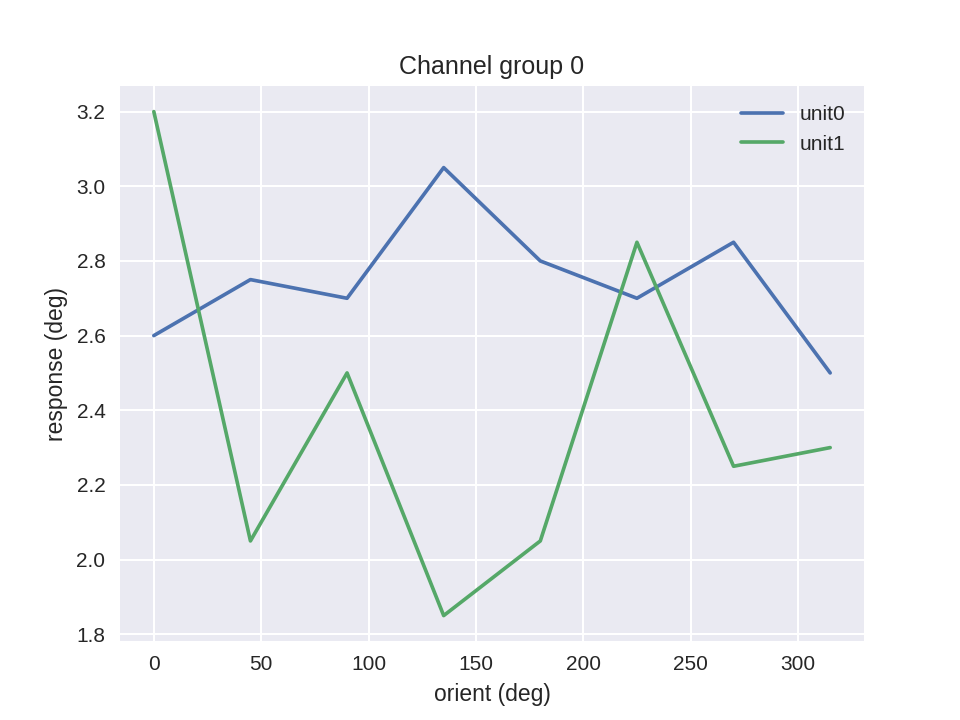

<IPython.core.display.Javascript object>


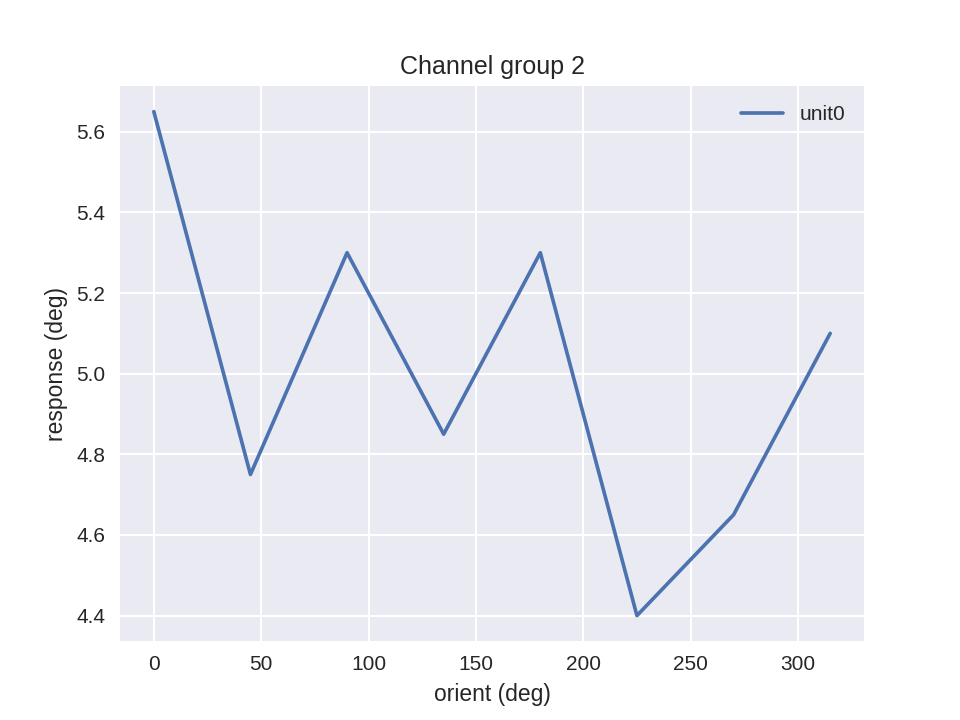

<IPython.core.display.Javascript object>


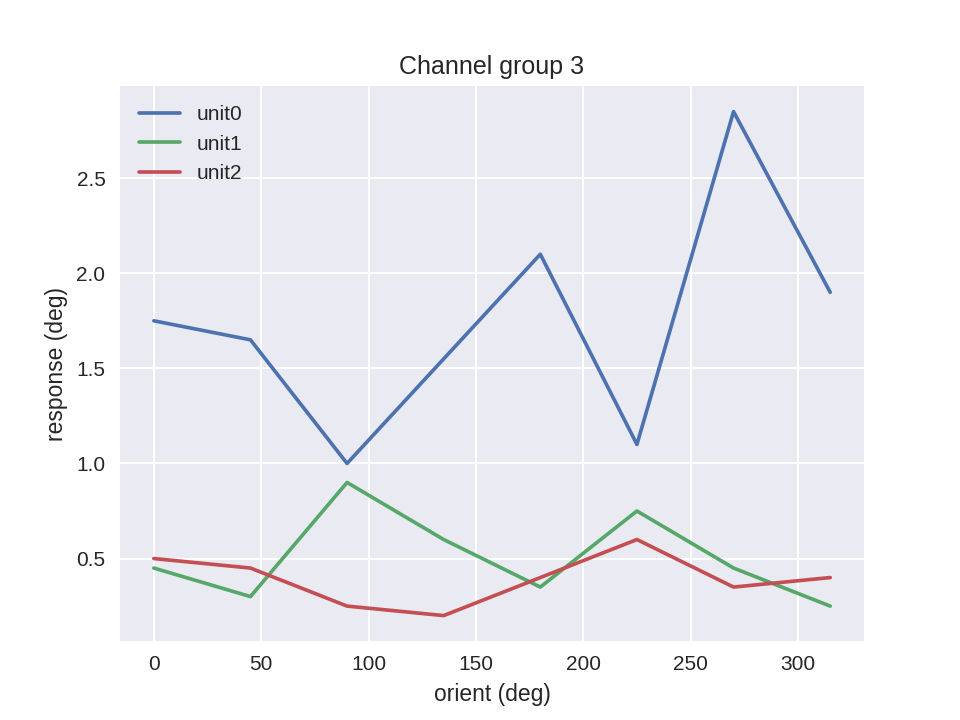

In [13]:
for chx_id, chx in stim_trials.items():
    plt.figure()
    for un_id, trials in chx.items():

        orients_trials = vs.data_processing.make_orientation_trials(trials)      # create orientation trials    
        rates, orients = vs.analysis.compute_orientation_tuning(orients_trials)  # compute orient tuning
        
        plt.plot(orients, rates, label="unit"+str(un_id))
        plt.xlabel("orient (deg)")
        plt.ylabel("response (deg)")
        plt.title(f"Channel group {str(chx_id)}")
    plt.legend()
